In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re
import joblib
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import os

### 1. Initialize the model

In [2]:
time_steps = [0, 0.1, 1, 20, 40, 60, 120, 180, 240, 300, 360, 480, 600, 720, 840, 960, 1080, 1200, 1500, 1800, 2400, 3000, 3600, 4500, 5400, 6300, 7200, 9000, 10800, 14400]

In [3]:
model = joblib.load("Step 3_RF_model_conc_normalized_n_estimators=120.joblib")

In [4]:
y_df = pd.read_hdf('y_df_oh.h5')

y_df.columns

Index(['Mechanism_(0, 146)', 'Mechanism_(0, 147)', 'Mechanism_(0, 154)',
       'Mechanism_(0, 155)', 'Mechanism_(1, 146)', 'Mechanism_(1, 147)',
       'Mechanism_(1, 154)', 'Mechanism_(1, 155)', 'Mechanism_(101, 126)',
       'Mechanism_(101, 162)',
       ...
       'Mechanism_(97, 128)', 'Mechanism_(97, 166)', 'Mechanism_(97, 167)',
       'Mechanism_(97, 181)', 'Mechanism_(97, 220)', 'Mechanism_(97, 221)',
       'Mechanism_(97, 338)', 'Mechanism_(97, 386)', 'Mechanism_(97, 404)',
       'Mechanism_(97, 452)'],
      dtype='object', length=456)

In [5]:
y_df

,"Mechanism_(0, 146)","Mechanism_(0, 147)","Mechanism_(0, 154)","Mechanism_(0, 155)","Mechanism_(1, 146)","Mechanism_(1, 147)","Mechanism_(1, 154)","Mechanism_(1, 155)","Mechanism_(101, 126)","Mechanism_(101, 162)",...,"Mechanism_(97, 128)","Mechanism_(97, 166)","Mechanism_(97, 167)","Mechanism_(97, 181)","Mechanism_(97, 220)","Mechanism_(97, 221)","Mechanism_(97, 338)","Mechanism_(97, 386)","Mechanism_(97, 404)","Mechanism_(97, 452)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933581,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1933582,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1933583,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1933584,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
database = pd.read_csv("database_two_reactions.csv")
df_database = database.drop(database.columns[0], axis=1)
df_database.head()

,Number of Reactions,Step,SM_left,C_left,B_left,P_right,IMP1_right,INT1_right,C_right,B_right,R_left,P_left,INT1_left,IMP2_right,Reaction Format,Initial Compounds
0,2,1,1,0,0,0,0,1,0,0,0,0,0,0,SM -> INT1,SM
1,2,1,1,0,0,0,0,1,0,0,1,0,0,0,SM + R -> INT1,"SM,R"
2,2,1,1,0,0,0,1,0,0,0,0,0,0,0,SM -> IMP1,"SM,IMP1"
3,2,1,1,0,0,0,1,0,0,0,1,0,0,0,SM + R -> IMP1,"SM,R,IMP1"
4,2,1,1,0,0,0,1,1,0,0,0,0,0,0,SM -> IMP1 + INT1,"SM,IMP1"


In [8]:
df_database.shape

(590, 16)

In [9]:
data_df = pd.read_csv("../two_reactions_022624.csv")

In [10]:
data_df.head()

,Unnamed: 0,Temperature,A1,Ea1,A2,Ea2,A3,Ea3,A4,Ea4,...,cINT1_10800s,cINT1_14400s,Fast_rxn1,Medium_rxn1,Slow_rxn1,Fast_rxn2,Medium_rxn2,Slow_rxn2,Reaction_order,Mechanism
0,0,273,0.034204,1,0.095650,182,0,0,0,0,...,0.007172,0.006560,0,0,1,0,0,1,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
1,1,273,0.004704,76,6.225530,65,0,0,0,0,...,0.000466,0.000450,0,0,1,0,1,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
2,2,273,0.016741,189,350.310546,149,0,0,0,0,...,0.000095,0.000088,0,0,1,1,0,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
3,3,273,0.483504,39,0.079969,10,0,0,0,0,...,0.009851,0.008435,0,1,0,0,0,1,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
4,4,273,2.633989,154,1.648038,127,0,0,0,0,...,0.001653,0.001348,0,1,0,0,1,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"


In [11]:
data_df = data_df.drop(data_df.columns[0], axis=1)

In [12]:
data_df.shape

(1933586, 257)

In [13]:
data_df.head()

,Temperature,A1,Ea1,A2,Ea2,A3,Ea3,A4,Ea4,cSM_0s,...,cINT1_10800s,cINT1_14400s,Fast_rxn1,Medium_rxn1,Slow_rxn1,Fast_rxn2,Medium_rxn2,Slow_rxn2,Reaction_order,Mechanism
0,273,0.034204,1,0.095650,182,0,0,0,0,0.3,...,0.007172,0.006560,0,0,1,0,0,1,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
1,273,0.004704,76,6.225530,65,0,0,0,0,0.3,...,0.000466,0.000450,0,0,1,0,1,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
2,273,0.016741,189,350.310546,149,0,0,0,0,0.3,...,0.000095,0.000088,0,0,1,1,0,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
3,273,0.483504,39,0.079969,10,0,0,0,0,0.3,...,0.009851,0.008435,0,1,0,0,0,1,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"
4,273,2.633989,154,1.648038,127,0,0,0,0,0.3,...,0.001653,0.001348,0,1,0,0,1,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(105, 197)"


In [14]:
def interpolation_savgol(original_time_course, original_time):
    original_time_course_copy = original_time_course.copy()
    original_time_copy = original_time.copy()
    savgol_curve = savgol_filter(original_time_course_copy, window_length=5, polyorder=1)
    interp_func = interp1d(original_time_copy, savgol_curve, kind='linear', fill_value="extrapolate")
    new_time_course = interp_func(time_steps).tolist()
    return new_time_course

# Normalization
def normalization(df_conc):
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Transpose the DataFrame so that rows become columns for scaling
    x_df_transposed = df_conc.T

    # Scale the entire transposed DataFrame
    scaled_data = scaler.fit_transform(x_df_transposed)

    # Transpose the scaled data back to the original orientation
    x_df = pd.DataFrame(scaled_data.T, columns=df_conc.columns, index=df_conc.index)
    return x_df

def generate_predicted_grouping(predictions):
    threshold = 0.8

    index = np.argsort(predictions) + 1
    prob = 0
    grouping = []
    probabilities = []
    for j in index[::-1]:
        prob += predictions[j - 1]
        grouping.append(j)
        probabilities.append(predictions[j - 1])
        if prob >= threshold:
            break
    return grouping, probabilities

In [15]:
def prediction(df_raw, n_columns, n_experiments, model):
    split_dfs = np.array_split(df_raw, n_experiments, axis=1)
    res_probilities = {}
    res_prediction = {}
    res_original_data = {}
    res_interpolated_data = {}

    for idx, df in enumerate(split_dfs):
        df = df.dropna(how='all')
        data_dict = {}
        for col_idx in range(n_columns + 1):
            column_name = df.columns[col_idx]
            data_dict[column_name.split()[0]] = df.iloc[:, col_idx].tolist()

        new_time_course = {}
        interpolated_data = {}
        for i in data_dict:
            if i == "Time":
                original_time = [value * 60 for value in data_dict[i]]
            else:
                new_time_course[i] = interpolation_savgol(data_dict[i], original_time)

        original_data = data_dict.copy()
        original_data['Time'] = original_time
        res_original_data[idx] = original_data
        interpolated_data['Time'] = time_steps
        interpolated_data.update(new_time_course)
        res_interpolated_data[idx] = interpolated_data

        species_list = list(new_time_course.keys())
        dfs = {}
        for species in species_list:
            df_species  = pd.DataFrame([new_time_course[species]], columns=[species + '_' + str(i) for i in range(len(new_time_course[species]))])
            dfs['df_' + species] = df_species
        
        num_rows = 1
        num_columns = 1 * len(time_steps)
        zero_df = pd.DataFrame(0, index=range(num_rows), columns=range(num_columns))
        species_list_full = ('SM', 'R', 'B', 'C', 'P', 'IMP1', 'IMP2', 'INT1')
        dfs_keys = [name.split('_')[1] for name in list(dfs.keys())]
        df_conc = dfs['df_SM']
        for j in range(1, len(species_list_full)):
            if species_list_full[j] in dfs_keys:
                df_conc = pd.concat([df_conc, dfs['df_' + species_list_full[j]]], axis=1)
            else:
                df_conc = pd.concat([df_conc, zero_df], axis=1)

        df_conc[df_conc < 0] = 0
        x_df = normalization(df_conc)
        pd.set_option('display.max_colwidth', None)
        x = x_df.to_numpy()

        y_predicted_proba = model.predict_proba(x)

        for idx_proba, i in enumerate(y_predicted_proba):
            grouping, probabilities = generate_predicted_grouping(i)
        mechanism_predicted = []
        for idx_group, k in enumerate(grouping):
            pattern = r'\((\d+), (\d+)\)'
            match = re.search(pattern, y_df.columns[k-1])
            idx_elementary_step_1 = int(match.group(1))
            idx_elementary_step_2 = int(match.group(2))
            elementary_step_1 = df_database.iloc[idx_elementary_step_1, -2]
            elementary_step_2 = df_database.iloc[idx_elementary_step_2, -2]
            mechanism_predicted.append([elementary_step_1, elementary_step_2])
        res_probilities[idx] = probabilities
        res_prediction[idx] = mechanism_predicted
        
    return res_probilities, res_prediction, res_original_data, res_interpolated_data


In [47]:
def plot(res_original_data, res_interpolated_data, output_dir='plots/'):

    # Define the rows you want to plot
    idx = range(0, len(res_original_data))
    # print(idx)

    # Define the variables to plot
    variables = list(res_original_data[0].keys())
    if 'Time' in variables:
        variables.remove('Time')

    # Set the number of subplots per row
    subplots_per_row = len(variables)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through each row
    for i in idx:
        # Create a new figure for each row
        # plt.figure(figsize=(15, 5))
        plt.figure(figsize=(3 * subplots_per_row, 4.5))

        # Loop through each variable
        for j, variable in enumerate(variables, start=1):
            plt.subplot(2, subplots_per_row, j)
            
            # Extract the relevant data
            original_data = res_original_data[i]
            interpolated_data = res_interpolated_data[i]

            # Plot the original data
            plt.scatter(original_data['Time'], original_data[variable], label='Experimental Data')

            # Plot the interpolated data
            plt.plot(interpolated_data['Time'], interpolated_data[variable], label='Interpolated Data') #, color='orange')

            # Set plot title
            plt.title(variable, fontsize=14, y = 1.05)

            # Set axis labels and axis size
            plt.xlabel('Time [s]', fontsize=12, labelpad=10)
            plt.ylabel('Concentration [mM]', fontsize=12, labelpad=10)

            # Set axis size
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.xlim(0, 30000)

        # plt.legend()
        plt.tight_layout()
        
        # plt.savefig(os.path.join(output_dir, f'Case study 2_plot_{i}.png'))
        # plt.savefig(os.path.join(output_dir, f'Case study 1_plot_{i}.png'))
        plt.show()
        plt.close()    
    

### 2. Case Studies

#### 2.1 Case Study 1: (SM + R + B -> P + B, P + R + B -> IMP2 + B)

In [48]:
df_raw = pd.read_csv("Case Studies/Case study 1.csv")
df_raw

,Time (min),SM (mM),R (mM),B (mM),P (mM),IMP2 (mM),Time (min).1,SM (mM).1,R (mM).1,B (mM).1,...,R (mM).3,B (mM).3,P (mM).3,IMP2 (mM).3,Time (min).4,SM (mM).4,R (mM).4,B (mM).4,P (mM).4,IMP2 (mM).4
0,0,204.902276,200.000000,161.856866,0.000000,0.000000,0.0,202.808732,400.341006,405.261122,...,150.127877,354.603482,0.000000,0.000000,0.0,204.340173,200.170503,810.522244,0.000000,0.000000
1,10,195.316856,195.068569,156.925435,4.931431,0.000000,15.0,190.890576,386.708428,391.848109,...,146.462487,350.938091,3.665391,0.000000,15.0,198.368989,193.778859,804.130600,6.391644,0.000000
2,20,193.205762,191.062516,152.919383,8.937484,0.000000,30.0,178.387149,374.515929,380.100775,...,143.162274,347.637878,6.965603,0.000000,30.0,193.475999,188.029123,798.380864,12.141380,0.000000
3,30,189.136680,187.090188,149.100460,12.756406,0.076703,45.0,168.634644,363.064995,369.365632,...,140.081119,344.556723,10.046758,0.000000,45.0,188.044962,182.258922,792.984155,17.538089,0.186746
4,45,184.308263,181.506256,143.673385,18.183482,0.155131,60.0,157.274370,352.731180,359.926661,...,136.747547,341.472213,13.131268,0.124531,60.0,183.226744,176.776735,787.639514,22.882730,0.255519
5,60,178.798099,176.029932,138.446715,23.410152,0.279958,90.0,140.196092,333.413976,342.972747,...,130.618301,335.720556,18.882926,0.313325,90.0,172.559786,166.885405,778.352579,32.169665,0.557716
6,90,169.872599,165.467693,128.433527,33.423340,0.554484,120.0,123.539688,316.526618,329.043822,...,125.002322,330.392369,24.211112,0.457221,120.0,162.526515,157.531183,769.754381,40.767863,0.935728
7,120,160.071471,156.322690,119.990141,41.866725,0.905293,180.0,90.391875,287.665483,307.469761,...,115.051459,321.236542,33.366940,0.854739,180.0,147.751687,140.765584,754.819787,55.702456,1.851231
8,180,144.996505,139.931777,105.351668,56.505199,1.781512,240.0,78.652102,264.798162,292.775243,...,106.451053,313.675200,40.928282,1.374271,240.0,133.390978,127.321575,743.323572,67.198672,2.825128
9,240,128.274066,126.516406,93.892408,67.964458,2.759568,360.0,54.391199,230.406907,276.317682,...,91.104213,300.618299,53.985182,2.519241,360.0,116.290196,106.380087,726.675190,83.847054,4.971681


In [49]:
n_experiments = 5
n_species = 5

res_probilities, res_prediction, res_original_data, res_interpolated_data = prediction(df_raw, n_species, n_experiments, model)


[179, 183, 154, 178, 156, 191, 344, 177, 182, 342, 456, 341, 147, 155, 152]
[0.21666666666666667, 0.10833333333333334, 0.075, 0.05, 0.05, 0.041666666666666664, 0.041666666666666664, 0.03333333333333333, 0.03333333333333333, 0.03333333333333333, 0.025, 0.025, 0.025, 0.025, 0.016666666666666666]
[179, 183, 344, 191, 156, 153, 342, 155, 154, 181, 150, 5]
[0.21666666666666667, 0.15, 0.06666666666666667, 0.058333333333333334, 0.058333333333333334, 0.05, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.03333333333333333, 0.03333333333333333, 0.025]
[179, 183, 191, 155, 153, 150, 156, 154]
[0.275, 0.20833333333333334, 0.06666666666666667, 0.06666666666666667, 0.058333333333333334, 0.05, 0.041666666666666664, 0.03333333333333333]
[183, 179, 154, 150, 153, 155, 191]
[0.225, 0.15, 0.125, 0.11666666666666667, 0.075, 0.06666666666666667, 0.05]
[179, 183, 151, 155, 181, 176, 452, 154]
[0.25833333333333336, 0.21666666666666667, 0.08333333333333333, 0.06666666666666667, 0.058333333

/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [50]:
print(res_probilities)

{0: [0.21666666666666667, 0.10833333333333334, 0.075, 0.05, 0.05, 0.041666666666666664, 0.041666666666666664, 0.03333333333333333, 0.03333333333333333, 0.03333333333333333, 0.025, 0.025, 0.025, 0.025, 0.016666666666666666], 1: [0.21666666666666667, 0.15, 0.06666666666666667, 0.058333333333333334, 0.058333333333333334, 0.05, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.03333333333333333, 0.03333333333333333, 0.025], 2: [0.275, 0.20833333333333334, 0.06666666666666667, 0.06666666666666667, 0.058333333333333334, 0.05, 0.041666666666666664, 0.03333333333333333], 3: [0.225, 0.15, 0.125, 0.11666666666666667, 0.075, 0.06666666666666667, 0.05], 4: [0.25833333333333336, 0.21666666666666667, 0.08333333333333333, 0.06666666666666667, 0.058333333333333334, 0.058333333333333334, 0.05, 0.041666666666666664]}


In [51]:
print(res_prediction)

{0: [['SM + B + R -> P + B', 'P + B + R -> IMP2 + B'], ['SM + B + R -> P + B', 'SM + P + B -> IMP2 + B'], ['SM + B + R -> B + INT1', 'B + INT1 -> P + B'], ['SM + B + R -> P + B', 'P + B -> IMP2 + B'], ['SM + B + R -> B + INT1', 'B + INT1 -> P + IMP2 + B'], ['SM + B + R -> P + B + INT1', 'P + R + INT1 -> IMP2'], ['SM + R -> P', 'SM + P -> IMP2'], ['SM + B + R -> P + B', 'B + R -> IMP2 + B'], ['SM + B + R -> P + B', 'SM + B -> IMP2 + B'], ['SM + R -> P', 'P + R -> IMP2'], ['SM + C + B + R -> P + B', 'SM + P + B -> IMP2 + C + B'], ['SM + R -> P', 'P -> IMP2'], ['SM + B -> B + INT1', 'B + R + INT1 -> P + B'], ['SM + B + R -> B + INT1', 'B + R + INT1 -> P + B'], ['SM + B + R -> B + INT1', 'INT1 -> P + IMP2']], 1: [['SM + B + R -> P + B', 'P + B + R -> IMP2 + B'], ['SM + B + R -> P + B', 'SM + P + B -> IMP2 + B'], ['SM + R -> P', 'SM + P -> IMP2'], ['SM + B + R -> P + B + INT1', 'P + R + INT1 -> IMP2'], ['SM + B + R -> B + INT1', 'B + INT1 -> P + IMP2 + B'], ['SM + B + R -> B + INT1', 'R + I

In [53]:
# The true mechanism is SM + R + B -> P + B, P + R + B -> IMP2 + B

data = {'Experiment #': [], 'Mechanism': [], 'Probability': []}

# Iterate through res_prediction
for i in res_prediction:
    # Iterate through mechanisms and probabilities
    for idx, mechanism_list in enumerate(res_prediction[i]):
        probability = res_probilities[i][idx]
        # Join the list elements into a single string
        mechanism = ',  '.join(mechanism_list)
        # Append data to lists
        data['Experiment #'].append(i)
        data['Mechanism'].append(mechanism)
        data['Probability'].append(probability)

# Create a DataFrame
df = pd.DataFrame(data)
df

,Experiment #,Mechanism,Probability
0,0,"SM + B + R -> P + B, P + B + R -> IMP2 + B",0.216667
1,0,"SM + B + R -> P + B, SM + P + B -> IMP2 + B",0.108333
2,0,"SM + B + R -> B + INT1, B + INT1 -> P + B",0.075000
3,0,"SM + B + R -> P + B, P + B -> IMP2 + B",0.050000
4,0,"SM + B + R -> B + INT1, B + INT1 -> P + IMP2 + B",0.050000
5,0,"SM + B + R -> P + B + INT1, P + R + INT1 -> IMP2",0.041667
6,0,"SM + R -> P, SM + P -> IMP2",0.041667
7,0,"SM + B + R -> P + B, B + R -> IMP2 + B",0.033333
8,0,"SM + B + R -> P + B, SM + B -> IMP2 + B",0.033333
9,0,"SM + R -> P, P + R -> IMP2",0.033333


In [511]:
df.to_csv('res_case study 1.csv', index=False)

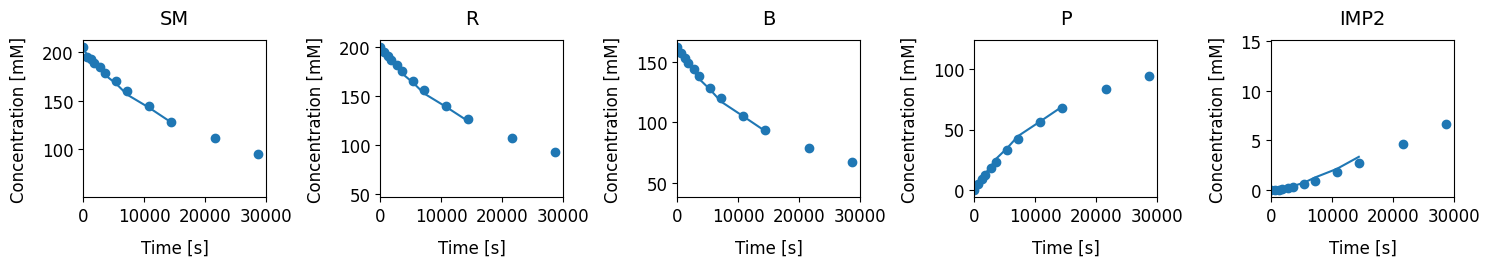

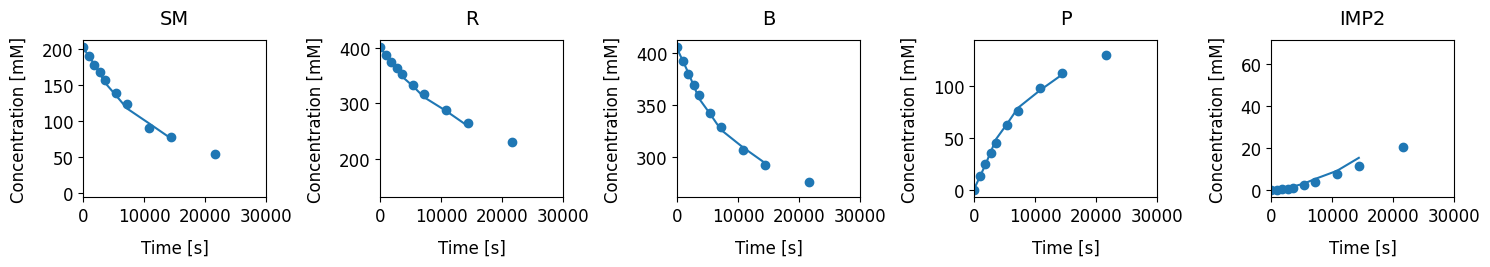

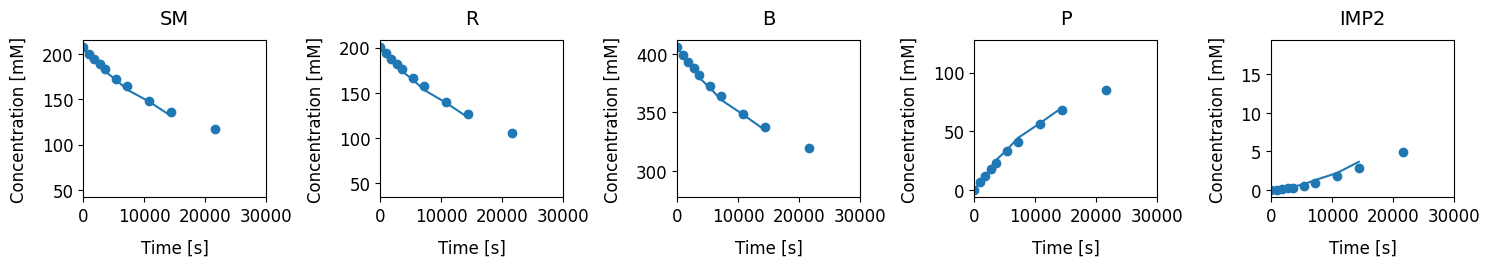

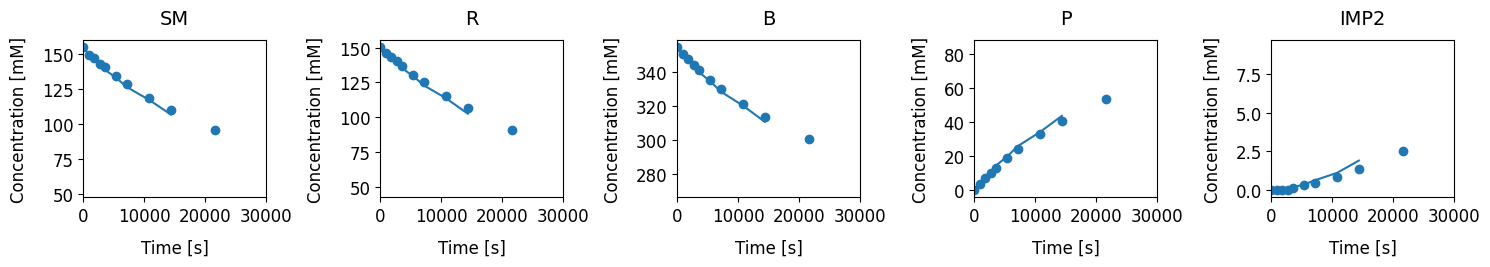

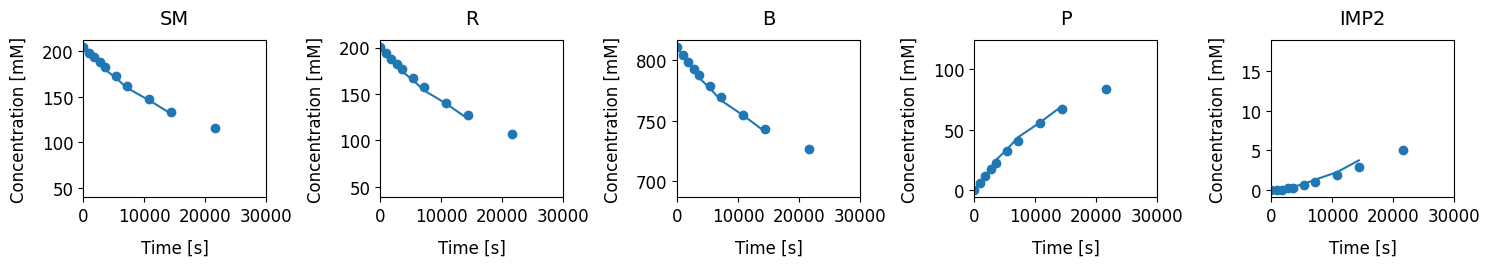

In [54]:
plot(res_original_data, res_interpolated_data) 

In [493]:
grouping = [179, 183, 154, 178, 156, 191, 344, 177, 182, 342, 456, 341, 147, 155, 152, 153, 181, 150, 5, 151, 176, 452]

In [494]:
true_mechanism_df = data_df[data_df['Mechanism'] == str((29, 217))]

In [495]:
true_mechanism_df

,Temperature,A1,Ea1,A2,Ea2,A3,Ea3,A4,Ea4,cSM_0s,...,cINT1_10800s,cINT1_14400s,Fast_rxn1,Medium_rxn1,Slow_rxn1,Fast_rxn2,Medium_rxn2,Slow_rxn2,Reaction_order,Mechanism
214034,273,0.023977,125,0.062190,149,0,0,0,0,0.3,...,0.0,0.0,0,0,1,0,0,1,"{'rxn1': {'SM': 1, 'B': 1, 'R': 1}, 'rxn_2': {'P': 1, 'B': 1, 'R': 1}}","(29, 217)"
214035,273,0.053240,56,9.835595,74,0,0,0,0,0.3,...,0.0,0.0,0,0,1,0,1,0,"{'rxn1': {'SM': 1, 'B': 1, 'R': 1}, 'rxn_2': {'P': 1, 'B': 1, 'R': 1}}","(29, 217)"
214036,273,0.021213,14,134.300199,6,0,0,0,0,0.3,...,0.0,0.0,0,0,1,1,0,0,"{'rxn1': {'SM': 1, 'B': 1, 'R': 1}, 'rxn_2': {'P': 1, 'B': 1, 'R': 1}}","(29, 217)"
214037,273,1.815907,161,0.015825,84,0,0,0,0,0.3,...,0.0,0.0,0,1,0,0,0,1,"{'rxn1': {'SM': 1, 'B': 1, 'R': 1}, 'rxn_2': {'P': 1, 'B': 1, 'R': 1}}","(29, 217)"
214038,273,3.325518,25,1.991739,49,0,0,0,0,0.3,...,0.0,0.0,0,1,0,0,1,0,"{'rxn1': {'SM': 1, 'B': 1, 'R': 1}, 'rxn_2': {'P': 1, 'B': 1, 'R': 1}}","(29, 217)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768531,273,3.648937,58,1.190083,21,0,0,0,0,0.3,...,0.0,0.0,0,1,0,0,1,0,"{'rxn1': {'SM': 2, 'B': 2, 'R': 2}, 'rxn_2': {'P': 2, 'B': 2, 'R': 2}}","(29, 217)"
1768532,273,9.533488,156,845.269909,44,0,0,0,0,0.3,...,0.0,0.0,0,1,0,1,0,0,"{'rxn1': {'SM': 2, 'B': 2, 'R': 2}, 'rxn_2': {'P': 2, 'B': 2, 'R': 2}}","(29, 217)"
1768533,273,823.826795,56,0.091007,118,0,0,0,0,0.3,...,0.0,0.0,1,0,0,0,0,1,"{'rxn1': {'SM': 2, 'B': 2, 'R': 2}, 'rxn_2': {'P': 2, 'B': 2, 'R': 2}}","(29, 217)"
1768534,273,786.118977,89,3.026795,12,0,0,0,0,0.3,...,0.0,0.0,1,0,0,0,1,0,"{'rxn1': {'SM': 2, 'B': 2, 'R': 2}, 'rxn_2': {'P': 2, 'B': 2, 'R': 2}}","(29, 217)"


In [496]:
conc_list = [col for col in true_mechanism_df.columns if col.endswith('s')]
true_mechanism_x = true_mechanism_df[conc_list]
scaler = MinMaxScaler()
true_mechanism_x_transposed = true_mechanism_x.T
scaled_data = scaler.fit_transform(true_mechanism_x_transposed)
true_mechanism_x = pd.DataFrame(scaled_data.T, columns=true_mechanism_x.columns, index=true_mechanism_x.index)
true_mechanism_x

,cSM_0s,cSM_0.1s,cSM_1s,cSM_20s,cSM_40s,cSM_60s,cSM_120s,cSM_180s,cSM_240s,cSM_300s,...,cINT1_2400s,cINT1_3000s,cINT1_3600s,cINT1_4500s,cINT1_5400s,cINT1_6300s,cINT1_7200s,cINT1_9000s,cINT1_10800s,cINT1_14400s
214034,0.333333,0.333088,0.330899,0.290399,0.257581,0.232218,0.183601,1.569823e-01,1.409035e-01,1.305241e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214035,0.333333,0.332773,0.327830,0.255848,0.215770,0.191767,0.157620,1.444961e-01,1.386091e-01,1.357871e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214036,0.333333,0.333106,0.331077,0.294830,0.266705,0.245338,0.204300,1.812328e-01,1.668942e-01,1.574174e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214037,0.333333,0.315938,0.211818,0.011282,0.002051,0.000473,0.000012,5.826323e-07,4.411452e-08,7.773798e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214038,0.333333,0.301000,0.159667,0.059132,0.059105,0.059105,0.059105,5.910544e-02,5.910544e-02,5.910544e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768531,0.333333,0.326183,0.280727,0.132799,0.105015,0.091402,0.072409,6.354946e-02,5.814510e-02,5.440707e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1768532,0.333333,0.316506,0.243543,0.128805,0.111924,0.103662,0.091990,8.644600e-02,8.302818e-02,8.065024e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1768533,0.333333,0.125787,0.049262,0.009066,0.005506,0.004032,0.002297,1.629541e-03,1.271392e-03,1.046867e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1768534,0.333333,0.128569,0.050851,0.010255,0.006724,0.005265,0.003538,2.859491e-03,2.487114e-03,2.248223e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [468]:
unrelated_groups = [group for group in range(1, 457) if group not in grouping]
# print(unrelated_groups)

In [469]:
all_groups = [179, 183, 154, 178, 156, 191, 344, 177, 182, 342, 456, 341, 147, 155, 152, 153, 181, 150, 5, 151, 176, 452, unrelated_groups]
print(all_groups)

[179, 183, 154, 178, 156, 191, 344, 177, 182, 342, 456, 341, 147, 155, 152, 153, 181, 150, 5, 151, 176, 452, [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 180, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

(29, 217)
(29, 448)
(17, 200)
(29, 216)
(17, 208)
(33, 171)
(7, 382)
(29, 179)
(29, 400)
(7, 163)
(97, 452)
(7, 162)
(16, 201)
(17, 201)
(17, 154)
(17, 155)
(29, 382)
(17, 146)
(1, 146)
(17, 147)
(29, 163)
(97, 221)


/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


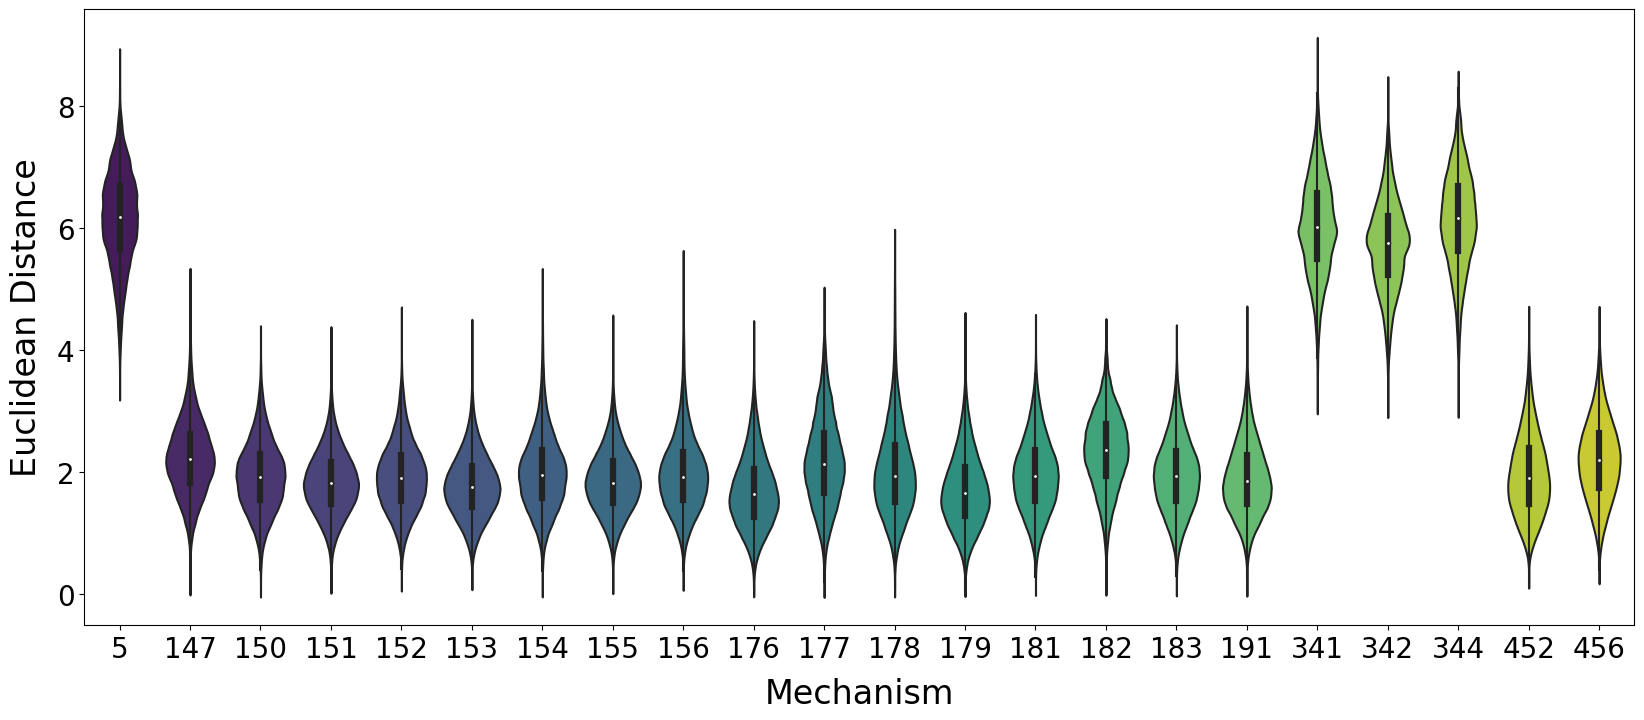

In [470]:
min_distances = []
idx_groups = []
distances_list = []
data = pd.DataFrame()  # Initialize an empty DataFrame to store the distances and mechanism labels

for idx_group, k in enumerate(grouping):
    pattern = r'\((\d+), (\d+)\)'
    match = re.search(pattern, y_df.columns[k-1])
    idx_elementary_step_1 = int(match.group(1))
    idx_elementary_step_2 = int(match.group(2))
    mechanism = (idx_elementary_step_1, idx_elementary_step_2)
    print(mechanism)
    mechanism_df = data_df[data_df['Mechanism'] == str(mechanism)]
    mechanism_x = mechanism_df[conc_list]
    scaler = MinMaxScaler()
    mechanism_x_transposed = mechanism_x.T
    scaled_data = scaler.fit_transform(mechanism_x_transposed)
    mechanism_x_scaled = pd.DataFrame(scaled_data.T, columns=mechanism_x.columns, index=mechanism_x.index)
    
    # Calculate Euclidean distances between each row in true_mechanism_x and mechanism_x_scaled
    distances = euclidean_distances(true_mechanism_x, mechanism_x_scaled)

    # Flatten the distances array
    flat_distances = distances.flatten()

    # Append the distances and mechanism labels to the DataFrame
    mechanism_labels = [k] * len(flat_distances)
    # mechanism_labels = ['Mechanism {}'.format(k)] * len(flat_distances)
    temp_df = pd.DataFrame({'Euclidean Distance': flat_distances, 'Mechanism': mechanism_labels})
    data = pd.concat([data, temp_df], ignore_index=True)

# Create a violin plot
plt.figure(figsize=(20, 8))
sns.violinplot(x='Mechanism', y='Euclidean Distance', data=data, palette='viridis')

# Set x-axis label, adjust font size, and add padding
plt.xlabel('Mechanism', fontsize=24, labelpad=10)

# Set y-axis label, adjust font size, and add padding
plt.ylabel('Euclidean Distance', fontsize=24, labelpad=10)

# Adjust x-axis and y-axis tick font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


#### 2.2 Test Case 2: (SM + R -> P, P + R -> IMP2)

In [ ]:
df_raw = pd.read_csv("Case Studies/Case study 2.csv")
df_raw

,Time (min),SM (mmol),P (mmol),IMP2 (mmol),Time (min).1,SM (mmol).1,P (mmol).1,IMP2 (mmol).1,Time (min).2,SM (mmol).2,...,P (mmol).3,IMP2 (mmol).3,Time (min).4,SM (mmol).4,P (mmol).4,IMP2 (mmol).4,Time (min).5,SM (mmol).5,P (mmol).5,IMP2 (mmol).5
0,0.0,10.054883,10.897773,0.048644,0.0,5.951306,14.787380,0.075807,0,8.315740,...,3.536454,0.026017,0,14.389620,3.401635,0.018203,0.0,3.133615,5.916848,0.035134
1,1.0,9.154893,11.608624,0.050950,2.0,5.538506,15.246775,0.082378,1,7.772086,...,4.132100,0.021766,1,13.712021,4.264338,0.020696,1.0,2.470655,6.601967,0.033216
2,3.0,8.659269,12.304911,0.037308,4.0,5.221095,15.653526,0.088615,3,7.568511,...,4.951082,0.023470,3,13.913854,4.418947,0.009280,3.0,2.021417,7.069514,0.044141
3,10.0,6.751891,14.131892,0.049031,9.0,4.489214,16.436043,0.110666,5,7.207536,...,5.277725,0.024900,5,12.333210,4.975389,0.013286,5.0,1.686399,7.463532,0.051491
4,20.0,5.267625,15.320413,0.061309,19.0,3.628831,17.123983,0.126293,10,6.211695,...,6.534729,0.033302,10,11.619568,5.968590,0.016615,10.0,0.495834,8.450171,0.461695
5,30.0,4.668068,16.240728,0.075154,29.0,2.867811,17.573150,0.139235,20,4.969617,...,7.697283,0.052927,20,10.762901,7.035085,0.012860,20.0,0.389470,8.701696,0.101093
6,60.0,3.257470,17.114613,0.101804,59.0,2.236235,18.161486,0.174036,30,4.695493,...,8.057533,0.047670,30,10.653514,7.735089,0.019549,60.0,0.030617,9.007869,0.214878
7,120.0,2.503555,18.079772,0.116162,119.0,1.639654,18.627261,0.217844,60,3.242582,...,8.935905,0.061670,60,9.912013,8.475547,0.019753,120.0,0.030768,8.881478,0.315151
8,240.0,1.878292,18.505627,0.135492,239.0,1.302857,18.517978,0.242845,120,2.363729,...,9.755502,0.076568,120,7.577391,8.537024,0.022786,240.0,0.012447,8.639504,0.613699
9,360.0,1.570946,18.998161,0.152411,359.0,1.123043,18.662728,0.262900,240,2.144355,...,10.294027,0.086403,240,8.693213,9.127908,0.027179,360.0,0.001343,8.218447,0.915917


In [ ]:
n_experiments = 6
n_species = 3

res_probilities, res_prediction, res_original_data, res_interpolated_data = prediction(df_raw, n_species, n_experiments, model)

[342, 340, 3]
[0.44166666666666665, 0.325, 0.058333333333333334]
[340, 342, 177, 343, 3]
[0.4, 0.25833333333333336, 0.06666666666666667, 0.058333333333333334, 0.05]
[342, 340, 393]
[0.49166666666666664, 0.25833333333333336, 0.09166666666666666]
[342, 340, 393]
[0.45, 0.30833333333333335, 0.06666666666666667]
[342, 340, 393]
[0.425, 0.35833333333333334, 0.1]
[342, 340, 343, 1, 177, 344]
[0.35833333333333334, 0.15, 0.125, 0.09166666666666666, 0.058333333333333334, 0.05]


/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
print(res_probilities)

{0: [0.44166666666666665, 0.325, 0.058333333333333334], 1: [0.4, 0.25833333333333336, 0.06666666666666667, 0.058333333333333334, 0.05], 2: [0.49166666666666664, 0.25833333333333336, 0.09166666666666666], 3: [0.45, 0.30833333333333335, 0.06666666666666667], 4: [0.425, 0.35833333333333334, 0.1], 5: [0.35833333333333334, 0.15, 0.125, 0.09166666666666666, 0.058333333333333334, 0.05]}


In [ ]:
print(res_prediction)

{0: [['SM + R -> P', 'P + R -> IMP2'], ['SM + R -> P', 'R -> IMP2'], ['SM -> INT1', 'INT1 -> P + IMP2']], 1: [['SM + R -> P', 'R -> IMP2'], ['SM + R -> P', 'P + R -> IMP2'], ['SM + B + R -> P + B', 'B + R -> IMP2 + B'], ['SM + R -> P', 'SM -> IMP2'], ['SM -> INT1', 'INT1 -> P + IMP2']], 2: [['SM + R -> P', 'P + R -> IMP2'], ['SM + R -> P', 'R -> IMP2'], ['SM -> P + INT1', 'INT1 -> IMP2']], 3: [['SM + R -> P', 'P + R -> IMP2'], ['SM + R -> P', 'R -> IMP2'], ['SM -> P + INT1', 'INT1 -> IMP2']], 4: [['SM + R -> P', 'P + R -> IMP2'], ['SM + R -> P', 'R -> IMP2'], ['SM -> P + INT1', 'INT1 -> IMP2']], 5: [['SM + R -> P', 'P + R -> IMP2'], ['SM + R -> P', 'R -> IMP2'], ['SM + R -> P', 'SM -> IMP2'], ['SM -> INT1', 'INT1 -> P'], ['SM + B + R -> P + B', 'B + R -> IMP2 + B'], ['SM + R -> P', 'SM + P -> IMP2']]}


In [ ]:
# The true mechanism is SM + R -> P, P + R -> IMP2

data = {'Experiment #': [], 'Mechanism': [], 'Probability': []}

# Iterate through res_prediction
for i in res_prediction:
    # Iterate through mechanisms and probabilities
    for idx, mechanism_list in enumerate(res_prediction[i]):
        # print(mechanism_list)
        probability = res_probilities[i][idx]
        # Join the list elements into a single string
        mechanism = ',  '.join(mechanism_list)
        # Append data to lists
        data['Experiment #'].append(i)
        data['Mechanism'].append(mechanism)
        data['Probability'].append(probability)

# Create a DataFrame
df = pd.DataFrame(data)
df

,Experiment #,Mechanism,Probability
0,0,"SM + R -> P, P + R -> IMP2",0.441667
1,0,"SM + R -> P, R -> IMP2",0.325000
2,0,"SM -> INT1, INT1 -> P + IMP2",0.058333
3,1,"SM + R -> P, R -> IMP2",0.400000
4,1,"SM + R -> P, P + R -> IMP2",0.258333
5,1,"SM + B + R -> P + B, B + R -> IMP2 + B",0.066667
6,1,"SM + R -> P, SM -> IMP2",0.058333
7,1,"SM -> INT1, INT1 -> P + IMP2",0.050000
8,2,"SM + R -> P, P + R -> IMP2",0.491667
9,2,"SM + R -> P, R -> IMP2",0.258333


In [ ]:
df.to_csv('res_case_study_2.csv', index=False)

Euclidean Distance for Predicted Mechanism

In [ ]:
grouping = [342, 340, 343, 1, 177, 344, 3, 393]

In [ ]:
true_mechanism_df = data_df[data_df['Mechanism'] == str((7, 163))]

In [ ]:
true_mechanism_df

,Temperature,A1,Ea1,A2,Ea2,A3,Ea3,A4,Ea4,cSM_0s,...,cINT1_10800s,cINT1_14400s,Fast_rxn1,Medium_rxn1,Slow_rxn1,Fast_rxn2,Medium_rxn2,Slow_rxn2,Reaction_order,Mechanism
202730,273,0.093891,10,0.011351,87,0,0,0,0,0.3,...,0.0,0.0,0,0,1,0,0,1,"{'rxn1': {'SM': 1, 'R': 1}, 'rxn_2': {'P': 1, 'R': 1}}","(7, 163)"
202731,273,0.003292,83,4.818212,146,0,0,0,0,0.3,...,0.0,0.0,0,0,1,0,1,0,"{'rxn1': {'SM': 1, 'R': 1}, 'rxn_2': {'P': 1, 'R': 1}}","(7, 163)"
202732,273,0.074048,92,490.984843,106,0,0,0,0,0.3,...,0.0,0.0,0,0,1,1,0,0,"{'rxn1': {'SM': 1, 'R': 1}, 'rxn_2': {'P': 1, 'R': 1}}","(7, 163)"
202733,273,9.873814,97,0.011139,57,0,0,0,0,0.3,...,0.0,0.0,0,1,0,0,0,1,"{'rxn1': {'SM': 1, 'R': 1}, 'rxn_2': {'P': 1, 'R': 1}}","(7, 163)"
202734,273,0.559118,98,2.656076,139,0,0,0,0,0.3,...,0.0,0.0,0,1,0,0,1,0,"{'rxn1': {'SM': 1, 'R': 1}, 'rxn_2': {'P': 1, 'R': 1}}","(7, 163)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756795,273,0.403615,99,9.441379,22,0,0,0,0,0.3,...,0.0,0.0,0,1,0,0,1,0,"{'rxn1': {'SM': 2, 'R': 2}, 'rxn_2': {'P': 2, 'R': 2}}","(7, 163)"
1756796,273,9.172688,171,415.203982,30,0,0,0,0,0.3,...,0.0,0.0,0,1,0,1,0,0,"{'rxn1': {'SM': 2, 'R': 2}, 'rxn_2': {'P': 2, 'R': 2}}","(7, 163)"
1756797,273,535.280431,182,0.010012,86,0,0,0,0,0.3,...,0.0,0.0,1,0,0,0,0,1,"{'rxn1': {'SM': 2, 'R': 2}, 'rxn_2': {'P': 2, 'R': 2}}","(7, 163)"
1756798,273,327.151844,118,3.529577,68,0,0,0,0,0.3,...,0.0,0.0,1,0,0,0,1,0,"{'rxn1': {'SM': 2, 'R': 2}, 'rxn_2': {'P': 2, 'R': 2}}","(7, 163)"


In [ ]:
conc_list = [col for col in true_mechanism_df.columns if col.endswith('s')]
true_mechanism_x = true_mechanism_df[conc_list]
scaler = MinMaxScaler()
true_mechanism_x_transposed = true_mechanism_x.T
scaled_data = scaler.fit_transform(true_mechanism_x_transposed)
true_mechanism_x = pd.DataFrame(scaled_data.T, columns=true_mechanism_x.columns, index=true_mechanism_x.index)
true_mechanism_x

,cSM_0s,cSM_0.1s,cSM_1s,cSM_20s,cSM_40s,cSM_60s,cSM_120s,cSM_180s,cSM_240s,cSM_300s,...,cINT1_2400s,cINT1_3000s,cINT1_3600s,cINT1_4500s,cINT1_5400s,cINT1_6300s,cINT1_7200s,cINT1_9000s,cINT1_10800s,cINT1_14400s
202730,0.833333,0.830538,0.806130,0.488018,0.336935,0.253812,0.141931,0.097754,0.075156,0.061882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202731,0.833333,0.833238,0.832382,0.814845,0.797421,0.780974,0.736751,0.698941,0.666275,0.637798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202732,0.833333,0.831207,0.812703,0.581206,0.478333,0.424876,0.361274,0.342840,0.336670,0.334508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202733,0.833333,0.617086,0.149387,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202734,0.833333,0.817551,0.698965,0.310690,0.295336,0.294194,0.294097,0.294097,0.294097,0.294097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756795,0.833333,0.830843,0.809592,0.586793,0.500466,0.453124,0.381718,0.346007,0.323306,0.307129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1756796,0.833333,0.784090,0.577946,0.288870,0.250993,0.233006,0.208341,0.197004,0.190166,0.185489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1756797,0.833333,0.327718,0.123512,0.021612,0.012963,0.009420,0.005289,0.003713,0.002871,0.002345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1756798,0.833333,0.386764,0.154276,0.034227,0.023843,0.019512,0.014296,0.012196,0.011023,0.010260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
unrelated_groups = [group for group in range(1, 457) if group not in grouping]
# print(unrelated_groups)

In [ ]:
all_groups = [342, 340, 343, 1, 177, 344, 3, 393, unrelated_groups]
print(all_groups)

[342, 340, 343, 1, 177, 344, 3, 393, [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

(7, 163)
(7, 126)
(7, 334)
(0, 146)
(29, 179)
(7, 382)
(0, 154)
(8, 138)


/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/py/conda/PyLib_Common/envs/boda2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


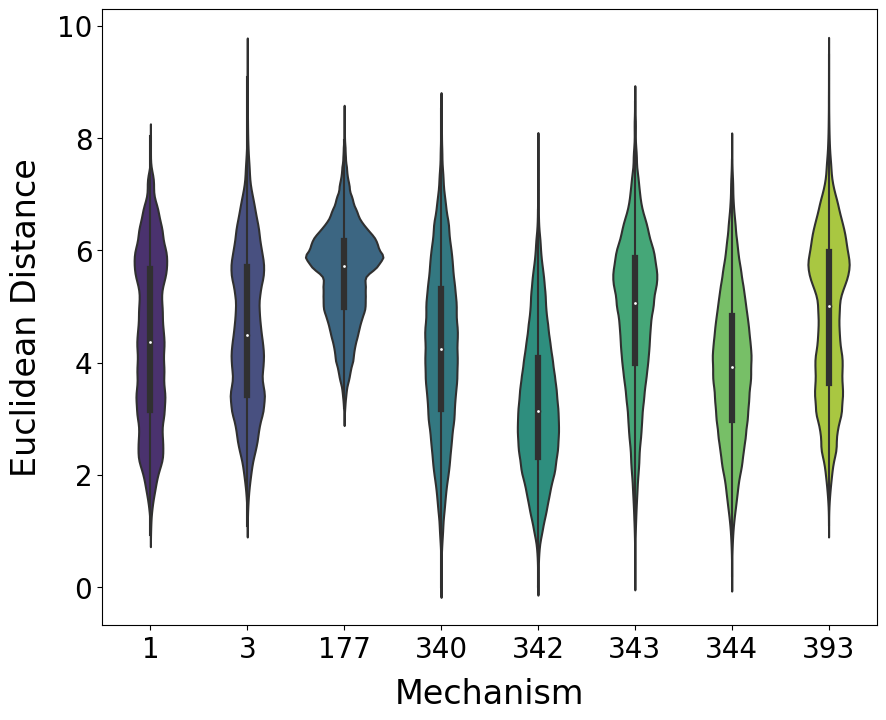

In [ ]:
min_distances = []
idx_groups = []
distances_list = []
data = pd.DataFrame()  # Initialize an empty DataFrame to store the distances and mechanism labels

for idx_group, k in enumerate(grouping):
    pattern = r'\((\d+), (\d+)\)'
    match = re.search(pattern, y_df.columns[k-1])
    idx_elementary_step_1 = int(match.group(1))
    idx_elementary_step_2 = int(match.group(2))
    mechanism = (idx_elementary_step_1, idx_elementary_step_2)
    print(mechanism)
    mechanism_df = data_df[data_df['Mechanism'] == str(mechanism)]
    mechanism_x = mechanism_df[conc_list]
    scaler = MinMaxScaler()
    mechanism_x_transposed = mechanism_x.T
    scaled_data = scaler.fit_transform(mechanism_x_transposed)
    mechanism_x_scaled = pd.DataFrame(scaled_data.T, columns=mechanism_x.columns, index=mechanism_x.index)
    
    # Calculate Euclidean distances between each row in true_mechanism_x and mechanism_x_scaled
    distances = euclidean_distances(true_mechanism_x, mechanism_x_scaled)

    # Flatten the distances array
    flat_distances = distances.flatten()

    # Append the distances and mechanism labels to the DataFrame
    mechanism_labels = [k] * len(flat_distances)
    temp_df = pd.DataFrame({'Euclidean Distance': flat_distances, 'Mechanism': mechanism_labels})
    data = pd.concat([data, temp_df], ignore_index=True)

# Create a violin plot
plt.figure(figsize=(10, 8))
sns.violinplot(x='Mechanism', y='Euclidean Distance', data=data, palette='viridis')

# Set x-axis label, adjust font size, and add padding
plt.xlabel('Mechanism', fontsize=24, labelpad=10)

# Set y-axis label, adjust font size, and add padding
plt.ylabel('Euclidean Distance', fontsize=24, labelpad=10)

# Adjust x-axis and y-axis tick font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


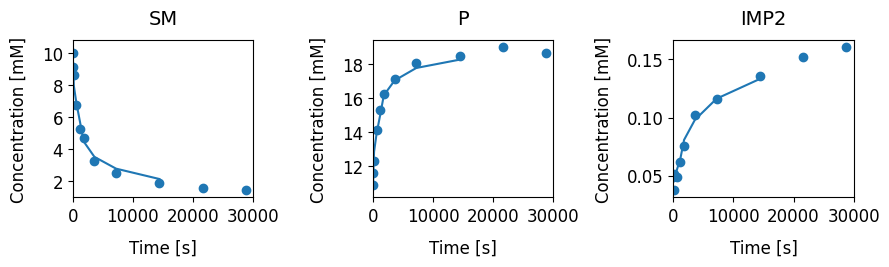

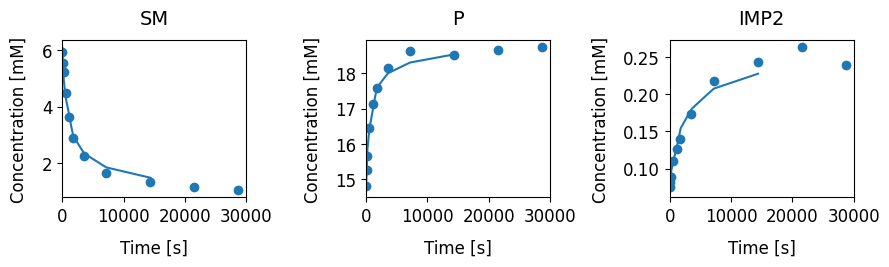

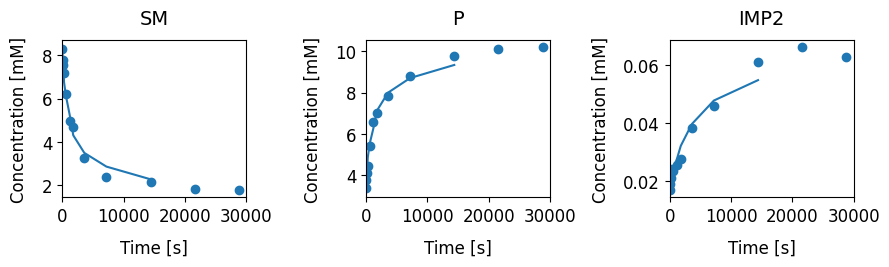

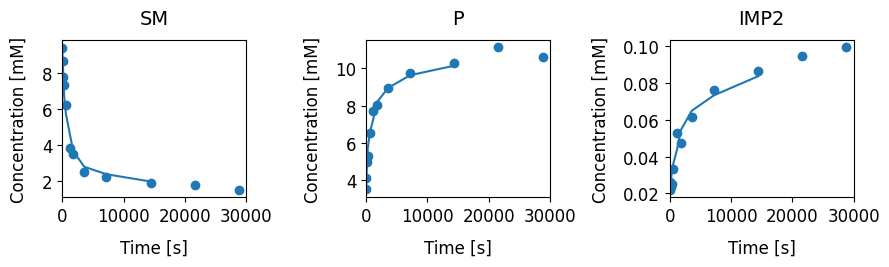

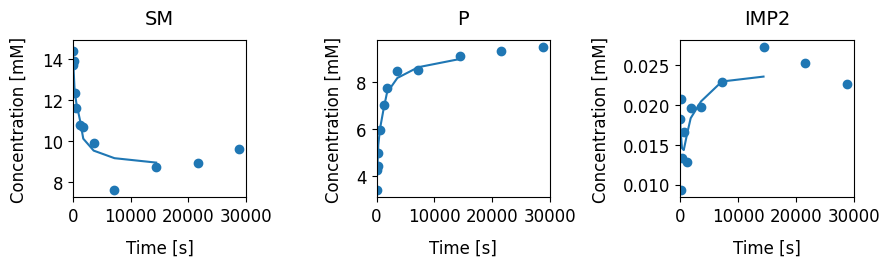

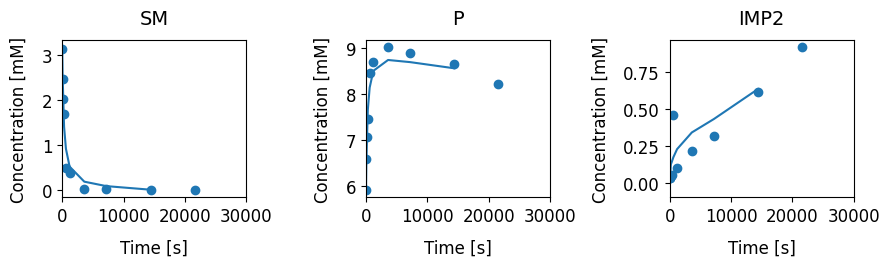

In [ ]:
plot(res_original_data, res_interpolated_data) 